In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error as mserr
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.neural_network import MLPClassifier

In [23]:
#read train and test datasets into pandas DataFrames trainx_df, trainy_df,testx_df
def readDataSets(train_path, test_path, predict_col, index_col = None):
    
    if index_col == None:
        trainx_df = pd.read_csv(train_path)
        trainy_df = trainx_df[predict_col]
        trainy_df.hist()
        trainx_df.drop(predict_col,axis = 1,inplace = True)
        testx_df = pd.read_csv(test_path)
    else:
        trainx_df = pd.read_csv(train_path,index_col = 'Id')
        trainy_df = trainx_df[predict_col]
        trainx_df.drop(predict_col,axis = 1,inplace = True)
        testx_df = pd.read_csv(test_path,index_col='Id')
    return trainx_df,trainy_df,testx_df

In [24]:
# As a first step of pre-processing remove columns with null value ratio greater than provided limit
def dropFeturesWithNullValuesGreaterThanALimit(trainx_df, testx_df, null_ratio = 0.3):
    sample_size = len(trainx_df)
    columns_with_null_values = [[col, float(trainx_df[col].isnull().sum())/float(sample_size)] for col in trainx_df.columns if trainx_df[col].isnull().sum()]
    columns_to_drop = [x for (x,y) in columns_with_null_values if y > null_ratio]
    trainx_df.drop(columns_to_drop, axis = 1, inplace = True)
    testx_df.drop(columns_to_drop, axis = 1, inplace = True)
    return trainx_df,testx_df


In [25]:

# As a second pre-processing step find all categorical columns and one hot  encode them. Before one hot encode fill all null values with dummy in those columns.  Some categorical columns in trainx_df may not have null values in trainx_df but have null values in testx_df. To overcome this problem we will add a row to the trainx_df with all dummy values for categorical values. Once one hot encoding is complete drop the added dummy column
def oneHotEncode(trainx_df,testx_df):
    categorical_columns = [col for col in trainx_df.columns if trainx_df[col].dtype == object]
    ordinal_columns = [col for col in trainx_df.columns if col not in categorical_columns]
    dummy_row = list()
    for col in trainx_df.columns:
        if col in categorical_columns:
            dummy_row.append("dummy")
        else:
            dummy_row.append("")
    new_row = pd.DataFrame([dummy_row], columns = trainx_df.columns)
    trainx_df = pd.concat([trainx_df,new_row], axis = 0, ignore_index = True)
    testx_df = pd.concat([testx_df],axis = 0, ignore_index = True)
    for col in categorical_columns:
        trainx_df[col].fillna(value = "dummy", inplace = True)
        testx_df[col].fillna(value = "dummy", inplace = True)
    enc = OneHotEncoder(drop = 'first', sparse = False)
    enc.fit(trainx_df[categorical_columns])
    trainx_enc = pd.DataFrame(enc.transform(trainx_df[categorical_columns]))
    testx_enc = pd.DataFrame(enc.transform(testx_df[categorical_columns]))
    trainx_enc.columns = enc.get_feature_names(categorical_columns)
    testx_enc.columns = enc.get_feature_names(categorical_columns)
    trainx_df = pd.concat([trainx_df[ordinal_columns], trainx_enc], axis = 1, ignore_index = True)
    testx_df = pd.concat([testx_df[ordinal_columns], testx_enc], axis = 1, ignore_index = True)
    trainx_df.drop(trainx_df.tail(1).index, inplace = True)
    return trainx_df,testx_df

In [26]:

# As a third step of pre-processing fill all missing values for ordinal features
def fillMissingValues(trainx_df,testx_df):
    imputer = KNNImputer(n_neighbors = 2)
    imputer.fit(trainx_df)
    trainx_df_filled = imputer.transform(trainx_df)
    trainx_df_filled = pd.DataFrame(trainx_df_filled, columns = trainx_df.columns)
    testx_df_filled = imputer.transform(testx_df)
    testx_df_filled = pd.DataFrame(testx_df_filled, columns = testx_df.columns)
    testx_df_filled.reset_index(drop = True, inplace = True)
    return trainx_df_filled,testx_df_filled

In [27]:

# As a fourth step of pre-processing scale all the features either through Standard scores or MinMax scaling
def scaleFetures(trainx_df,testx_df,scale = 'Standard'):
    if scale == 'Standard':
        scaler = preprocessing.StandardScaler().fit(trainx_df)
        trainx_df = scaler.transform(trainx_df)
        testx_df = scaler.transform(testx_df)
    elif scale == 'MinMax':
        scaler = preprocessing.MinMaxScaler().fit(trainx_df)
        trainx_df = scaler.transform(trainx_df)
        testx_df = scaler.transform(testx_df)
    return trainx_df,testx_df

In [28]:

#As fifth step of preprocessing apply PCA
def findPrincipalComponents(trainx_df, testx_df):
    pca = PCA().fit(trainx_df)
    itemindex = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9999)
    print('np.cumsum(pca.explained_variance_ratio_)', np.cumsum(pca.explained_variance_ratio_))
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure(np.cumsum(pca.explained_variance_ratio_)[0])
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') 
    #for each component
    plt.title('Principal Components Explained Variance')
    plt.show()
    pca_std = PCA(n_components=itemindex[0][0]).fit(trainx_df)
    trainx_df = pca_std.transform(trainx_df)
    testx_df = pca_std.transform(testx_df)
    return trainx_df, testx_df


In [29]:

# Change labels into 0 and 1
def encodeLabelsToZeroAndOne(trainy_df):
    le = preprocessing.LabelEncoder()
    trainy_df = le.fit_transform(trainy_df)
    return trainy_df

In [30]:
# As a fifth step of pre-processing split the trainx_df into tow parts to build a model and test how is it working to pick best model
def splitTrainAndTest(trainx_df, trainy_df,split_ratio=0.3):
    X_train, X_test, y_train, y_test = train_test_split(trainx_df, trainy_df, test_size=split_ratio, random_state=42)
    return X_train, X_test, y_train, y_test

In [31]:
# Fit Logistic Regression Model
def getLogisticRegressionModel(X_train, y_train, reg_par = 0.00001, max_iterations = 1000000):
    logreg = LogisticRegression(class_weight = "balanced", C = reg_par, max_iter = max_iterations)
    logreg.fit(X_train, y_train)
    return logreg

In [32]:

#Fit SVM Classification Model
def getSVClassificationModel(X_train, y_train, reg_par = 1.0, deg = 3, ker = 'rbf'):
    svcmodel = SVC(C = reg_par, degree = deg, kernel=ker)
    svcmodel.fit(X_train, y_train)
    return svcmodel

In [33]:

#get BackPropagation Model MLP classifier in scikitlearn we can see hidden layers
def getBackPropagationModel(X_train, y_train,sol = 'lbfgs', reg_par = 1e-5, hid_layer_sizes = (5, ), random_state = 1, maxi_iter = 1000):
    nn_bp_model = MLPClassifier(solver = sol, alpha = reg_par, hidden_layer_sizes = hid_layer_sizes, random_state = 1, max_iter = maxi_iter)
    nn_bp_model.fit(X_train, y_train)
    return nn_bp_model

In [34]:
# K-means model
def getKmeansClusteringModel(X_train, y_train, n_clusts = 8, n_init = 10, max_iter = 300, tol = 0.0001):
        KmeansModel = KMeans(n_clusters = n_clusts, random_state = 0).fit(X_train)
        return KmeansModel

In [35]:
def getScores(model,X_train, X_test, y_train, y_test):
    '''THRESHOLD = 0.5
    yhat = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)'''
    yprobs = model.predict_log_proba(X_test)
    yprobs = yprobs[:,1]
    ras = roc_auc_score(y_test,yprobs,average = 'weighted')
    print(ras)
    yhat = model.predict(X_test)
    
    #pd.DataFrame(yhat).to_csv(model)
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(yhat)):
        if yhat[i] == 0:
            if y_test[i] == 0:
                TN += 1
            else:
                FN += 1
        else:
            if y_test[i] == 1:
                TP += 1
            else:
                FP += 1
    print(classification_report(y_test, yhat))
    print(classification_report(y_test,yhat,output_dict = True)['1']['precision'], classification_report(y_test, yhat, output_dict = True)['1']['recall'])
    fpr, tpr, threshold = roc_curve(y_test, yprobs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return([TP, TN, FP, FN, TP/(TP + FN), TN/(TN + FP)])

In [36]:
# get Scores for SVC
def getScoresForSVC(model, X_train, X_test, y_train, y_test):
    yhat = model.predict(X_test)  
    #pd.DataFrame(yhat).to_csv(model)
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(yhat)):
        if yhat[i] == 0:
            if y_test[i] == 0:
                TN += 1
            else:
                FN += 1
        else:
            if y_test[i] == 1:
                TP += 1
            else:
                FP += 1
    print(classification_report(y_test, yhat))
    print(classification_report(y_test, yhat, output_dict=True)['1']['precision'], classification_report(y_test, yhat, output_dict = True)['1']['recall'])
    return([TP, TN, FP, FN, TP/(TP + FN), TN/(TN + FP)])

np.cumsum(pca.explained_variance_ratio_) [0.10556106 0.15411495 0.19643988 0.23476932 0.2719896  0.3049957
 0.3359417  0.36529616 0.39313832 0.42013794 0.44601909 0.47087749
 0.49432268 0.51660722 0.53833372 0.55899851 0.57945657 0.59973984
 0.61987363 0.6398666  0.6593861  0.67761315 0.69576557 0.71344004
 0.73105196 0.74848247 0.76573186 0.78243455 0.79904326 0.81549941
 0.83176839 0.84745606 0.86288147 0.87829062 0.89315374 0.9074046
 0.92053081 0.93347961 0.94606333 0.95672836 0.96512835 0.97160422
 0.97790947 0.98211859 0.986221   0.98967053 0.99294856 0.99488901
 0.99666183 0.99788993 0.99891246 0.99989747 0.99996474 0.99999991
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


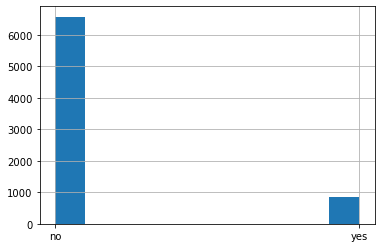

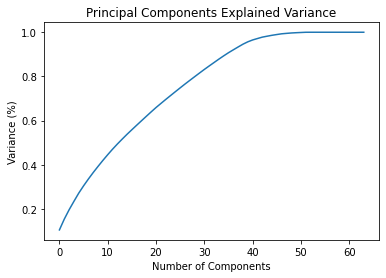

0.7793393572616478
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1942
           1       0.37      0.60      0.46       283

    accuracy                           0.82      2225
   macro avg       0.65      0.72      0.67      2225
weighted avg       0.86      0.82      0.84      2225

0.3706140350877193 0.5971731448763251


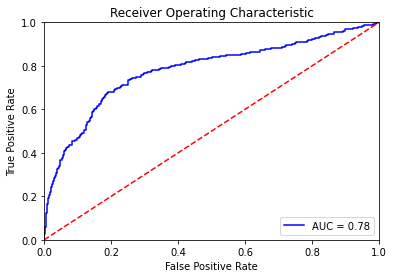

Results for SVM Classifier


In [37]:
# Tune regularization Parameter based on f1 value or mse
def predictTestx(Model, testx_df):
    testpred = pd.DataFrame(Model.predict(testx_df))
    testpred.to_csv("test_pred.csv")

trainx_df, trainy_df, testx_df = readDataSets("C:\\Users\\HARIKA\\Desktop\\DataScience_2019501065\\Intro_to_ML\\CodeCamp-2\\SparkCognition_Data Scientist_Challenge_Materials\\marketing_training.csv","C:\\Users\\HARIKA\\Desktop\\DataScience_2019501065\\Intro_to_ML\\CodeCamp-2\\SparkCognition_Data Scientist_Challenge_Materials\\marketing_test.csv", predict_col='responded')
trainx_df, testx_df = dropFeturesWithNullValuesGreaterThanALimit(trainx_df, testx_df,null_ratio=0.5)
trainx_df, testx_df = oneHotEncode(trainx_df, testx_df)
trainx_df, testx_df = fillMissingValues(trainx_df, testx_df)
trainx_df, testx_df = scaleFetures(trainx_df, testx_df, scale ='Standard')
trainy_df = encodeLabelsToZeroAndOne(trainy_df)
trainx_df, testx_df = findPrincipalComponents(trainx_df, testx_df)
X_train, X_test, y_train, y_test = splitTrainAndTest(trainx_df, trainy_df, split_ratio = 0.3)
LogRegModel = getLogisticRegressionModel(X_train, y_train)
getScores(LogRegModel, X_train, X_test, y_train, y_test)
print("Results for SVM Classifier")

0.7156577860425848
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1942
           1       0.51      0.26      0.34       283

    accuracy                           0.87      2225
   macro avg       0.71      0.61      0.64      2225
weighted avg       0.85      0.87      0.86      2225

0.5140845070422535 0.2579505300353357


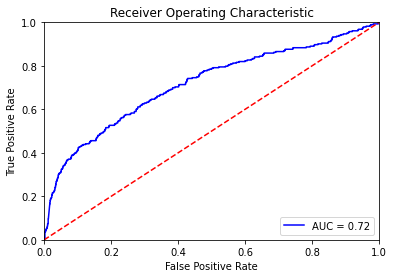

'LRModel=getLinearRegressionModel(X_train, y_train)\nRidgeModel=getRidgeRegressionModel(X_train, y_train,tolerence=0.0001,reg_par=0.5)\ngetRSqureandMSEVsAlphaPlots(X_train, X_test, y_train, y_test,alpha_start=130,alpha_end=146,jumps=10)'

In [38]:
nn_bp_model = getBackPropagationModel(X_train, y_train, sol = 'lbfgs', reg_par = 0.01, hid_layer_sizes = (7, ), random_state = 1, maxi_iter = 10000)
getScores(nn_bp_model, X_train, X_test, y_train, y_test)
'''LRModel=getLinearRegressionModel(X_train, y_train)
RidgeModel=getRidgeRegressionModel(X_train, y_train,tolerence=0.0001,reg_par=0.5)
getRSqureandMSEVsAlphaPlots(X_train, X_test, y_train, y_test,alpha_start=130,alpha_end=146,jumps=10)'''

In [39]:

svcmodel = getSVClassificationModel(X_train, y_train, reg_par = 0.5, deg = 2, ker = 'poly')
getScoresForSVC(svcmodel, X_train, X_test, y_train, y_test)
print("Results for Back Propagation Classifier")

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1942
           1       0.71      0.18      0.29       283

    accuracy                           0.89      2225
   macro avg       0.80      0.59      0.62      2225
weighted avg       0.87      0.89      0.86      2225

0.7123287671232876 0.18374558303886926
Results for Back Propagation Classifier
